In [1]:
import csv
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split


In [2]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

In [3]:
NUM_CLASSES = 33

In [4]:
# import pandas as pd
# import numpy as np

# # Load the dataset into a pandas DataFrame
# df = pd.read_csv(dataset, delimiter=',', dtype='float32', usecols=list(range(1, 150 + 1)))

# # Forward fill missing values along the columns
# df_filled = df.ffill()

# # Convert the filled DataFrame to a NumPy array
# X_dataset = df_filled.to_numpy(dtype='float32')

X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1,150+1)))
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))



C:\Users\gamer\AppData\Local\Temp\ipykernel_24064\286305184.py:14: DeprecationWarning: loadtxt(): Parsing an integer via a float is deprecated.  To avoid this warning, you can:
    * make sure the original data is stored as integers.
    * use the `converters=` keyword argument.  If you only use
      NumPy 1.23 or later, `converters=float` will normally work.
    * Use `np.loadtxt(...).astype(np.int64)` parsing the file as
      floating point and then convert it.  (On all NumPy versions.)
  (Deprecated NumPy 1.23)
  y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))


In [5]:
# import numpy as np
# from sklearn.preprocessing import LabelEncoder

# # Load your dataset with string labels
# y_dataset_str = np.loadtxt(dataset, delimiter=',', dtype='str', usecols=(0))

# # Convert string labels to integer labels using LabelEncoder
# label_encoder = LabelEncoder()
# y_dataset_int = label_encoder.fit_transform(y_dataset_str)

# Check the unique integer labels
unique_labels = np.unique(y_dataset)
print("Unique Integer Labels:",unique_labels)

Unique Integer Labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


In [6]:
print("Length of X_dataset:", len(X_dataset))
print("Length of y_dataset:", len(y_dataset))



Length of X_dataset: 9373
Length of y_dataset: 9373


In [12]:
X_dataset.shape

(9373, 150)

In [7]:
RANDOM_SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

In [8]:
# Assuming y_train and y_test are your original labels
# y_train_corrected = np.clip(y_train, 0, NUM_CLASSES - 1)
# y_test_corrected = np.clip(y_test, 0, NUM_CLASSES - 1)

# Verify that label values are within the valid range
print(np.unique(y_train))  # Should print [0 1 2 3]
# print(np.unique(y_test_corrected))   # Should also print [0 1 2 3]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]


In [34]:
import tensorflow as tf
from tensorflow.keras import layers

class WeightedInputLayer(layers.Layer):
    def __init__(self, num_features, importance_factor=1.0, importance_multiplier=1.5, important_column_start=82, **kwargs):
        super(WeightedInputLayer, self).__init__(**kwargs)
        self.num_features = num_features
        self.importance_factor = importance_factor
        self.importance_multiplier = importance_multiplier
        self.important_column_start = important_column_start
        self.custom_weights = self.add_weight(shape=(num_features,), initializer=tf.keras.initializers.Ones(), trainable=True)

    def call(self, inputs):
        weighted_inputs = inputs * tf.expand_dims(
            tf.where(tf.range(inputs.shape[1]) >= self.important_column_start, self.importance_multiplier, 1.0),
            axis=0
        ) * self.importance_factor * tf.expand_dims(self.custom_weights, axis=0)
        return weighted_inputs

    def get_config(self):
        config = super(WeightedInputLayer, self).get_config()
        config.update({
            'num_features': self.num_features,
            'importance_factor': self.importance_factor,
            'importance_multiplier': self.importance_multiplier,
            'important_column_start': self.important_column_start,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

# Define the model with weighted input layer
model = tf.keras.models.Sequential([
    WeightedInputLayer(150, importance_factor=1.0, importance_multiplier=3.0, important_column_start=82),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(240, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

# Build the model using the correct input shape
input_shape = (150,)  # Assuming each sample has 150 features
model.build((None,)+input_shape)

In [35]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 weighted_input_layer_7 (Wei  (None, 150)              150       
 ghtedInputLayer)                                                
                                                                 
 dropout_12 (Dropout)        (None, 150)               0         
                                                                 
 dense_18 (Dense)            (None, 240)               36240     
                                                                 
 dropout_13 (Dropout)        (None, 240)               0         
                                                                 
 dense_19 (Dense)            (None, 120)               28920     
                                                                 
 dense_20 (Dense)            (None, 33)                3993      
                                                      

In [36]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [37]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [38]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
51/55 [==========================>...] - ETA: 0s - loss: 2.2532 - accuracy: 0.3562
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
55/55 [==============================] - 2s 15ms/step - loss: 2.1935 - accuracy: 0.3723 - val_loss: 0.9650 - val_accuracy: 0.7381
Epoch 2/1000
48/55 [=========================>....] - ETA: 0s - loss: 1.0492 - accuracy: 0.6746
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
55/55 [==============================] - 0s 9ms/step - loss: 1.0223 - accuracy: 0.6836 - val_loss: 0.5690 - val_accuracy: 0.8618
Epoch 3/1000
52/55 [===========================>..] - ETA: 0s - loss: 0.7651 - accuracy: 0.7686
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
55/55 [==============================] - 0s 8ms/step - loss: 0.7608 - accuracy: 0.7705 - val_loss: 0.4929 - val_accuracy: 0.8665
Epoch 4/1000
52/55 [===========================>..] - ETA: 0s - loss: 0.6581 - accuracy: 0.8053


In [25]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

19/19 [==============================] - 0s 3ms/step - loss: 0.2004 - accuracy: 0.9428


In [39]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path, custom_objects={'WeightedInputLayer': WeightedInputLayer})

In [30]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 280ms/step
[3.5205493e-12 6.6983509e-11 6.3706233e-20 2.7527258e-24 3.3105592e-22
 7.6963000e-25 5.5771817e-18 4.2222938e-18 9.7866388e-21 8.1496523e-14
 1.6668361e-11 1.0000000e+00 3.5520250e-21 5.4594344e-16 5.1685036e-20
 1.4350957e-10 1.8984694e-12 4.5054118e-23 3.0329539e-19 1.2923787e-16
 4.0471502e-17 1.9250287e-24 1.1564477e-12 2.2789717e-12 6.4771821e-16
 6.8931548e-11 1.0844109e-20 1.8304737e-25 5.5227102e-25 2.4396269e-16
 2.7329046e-12 4.7628743e-24 2.2623330e-19]
11


74/74 [==============================] - 0s 3ms/step


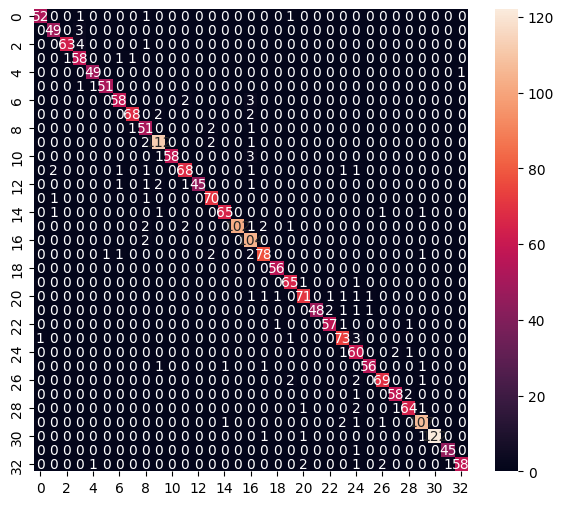

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        55
           1       0.92      0.94      0.93        52
           2       0.98      0.93      0.95        68
           3       0.87      0.95      0.91        61
           4       0.96      0.98      0.97        50
           5       0.98      0.96      0.97        53
           6       0.94      0.92      0.93        63
           7       0.97      0.94      0.96        72
           8       0.82      0.93      0.87        55
           9       0.94      0.96      0.95       117
          10       1.00      0.94      0.97        62
          11       0.93      0.91      0.92        75
          12       1.00      0.88      0.94        51
          13       0.92      0.97      0.95        72
          14       0.97      0.94      0.96        69
          15       1.00      0.93      0.96       110
          16       0.87      0.98      0.92       106
     

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

In [40]:

# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [41]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

74256

In [1]:
import cv2

In [3]:
cap = cv2.VideoCapture(0)
cap.release()
cv2.destroyAllWindows()